## Define Plan and Index

In [1]:
from palimpzest.datamanager import DataDirectory
from palimpzest.corelib import Schema
from ragatouille import RAGPretrainedModel
import palimpzest as pz
import datasets

class BiodexEntry(Schema):
    """A single entry in the Biodex ICSR Dataset."""

    pmid = pz.StringField(desc="The PubMed ID of the medical paper", required=True)
    title = pz.StringField(desc="The title of the medical paper", required=True)
    abstract = pz.StringField(desc="The abstract of the medical paper", required=True)
    fulltext = pz.StringField(desc="The full text of the medical paper, which contains information relevant for creating a drug safety report.", required=True)

class BiodexReactions(BiodexEntry):
    """
    You will be presented with the text of a medical article which is partially or entirely about
    an adverse event experienced by a patient in response to taking one or more drugs. In this task,
    you will be asked to extract a list of the primary adverse reactions which are experienced by the patient.
    """
    # reactions = pz.ListField(desc="The **list** of the adverse reaction(s) which may have resulted from taking the drug(s) discussed in the report.\n - For example: [\"Epstein-Barr virus\", \"infection reactivation\", \"Idiopathic interstitial pneumonia\"]", element_type=pz.StringField, required=True)
    reactions = pz.ListField(desc="The list of the adverse reaction term(s) which may have resulted from taking the drug(s) discussed in the report.", element_type=pz.StringField, required=True)

class BiodexReactionLabels(BiodexReactions):
    """
    Retrieve the labels which are most relevant for the given set of inferred reactions.
    """
    reaction_labels = pz.ListField(desc="Most relevant official terms for adverse reactions for the provided `reactions`",
                                   element_type=pz.StringField, required=True)

class BiodexRankedReactions(BiodexReactionLabels):
    """
    You will be presented with the text of a medical article which is partially or entirely about
    an adverse event experienced by a patient in response to taking one or more drugs. You will also
    be presented with a list of inferred reactions, and a set of retrieved labels which were matched
    to these inferred reactions. In this task, you are asked to output a ranked list of the labels
    which are most applicable based on the context of the article. Your output list must:
    - contain only elements from `reaction_labels`
    - place the most likely label first and the least likely label last
    - you may omit labels if you think they do not describe a reaction experienced by the patient
    """
    ranked_reaction_labels = pz.ListField(desc="The ranked list of labels for adverse reactions experienced by the patient. The most likely label occurs first in the list.",
                                          element_type=pz.StringField, required=True)


class BiodexValidationSource(pz.ValidationDataSource):
    def __init__(self, datasetId, reactions_only: bool=True, rp_at_k: int=5, num_samples: int=5, shuffle: bool=False, seed: int=42):
        super().__init__(BiodexEntry, datasetId)
        self.dataset = datasets.load_dataset("BioDEX/BioDEX-ICSR")
        self.train_dataset = [self.dataset['train'][idx] for idx in range(100)]
        self.test_dataset = [self.dataset['train'][idx] for idx in range(100, 150)]

        # sample from full test dataset
        # self.test_dataset = [self.dataset['test'][idx] for idx in range(len(self.dataset['test']))]
        # self.test_dataset = self.test_dataset[:250] # use first 250 to compare directly with biodex

        self.reactions_only = reactions_only
        self.rp_at_k = rp_at_k
        self.num_samples = num_samples
        self.shuffle = shuffle
        self.seed = seed

        # construct mapping from listing --> label (field, value) pairs
        def compute_target_record(entry, reactions_only: bool=False):
            target_lst = entry['target'].split('\n')
            label_dict = {
                "serious": int(target_lst[0].split(':')[-1]),
                "patientsex": int(target_lst[1].split(':')[-1]),
                "drugs": [drug.strip().lower() for drug in target_lst[2].split(':')[-1].split(",")],
                "reactions": [reaction.strip().lower() for reaction in target_lst[3].split(':')[-1].split(",")],
                "reaction_labels": [reaction.strip().lower() for reaction in target_lst[3].split(':')[-1].split(",")],
                "ranked_reaction_labels": [reaction.strip().lower() for reaction in target_lst[3].split(':')[-1].split(",")],
            }
            if reactions_only:
                label_dict = {
                    k: v
                    for k, v in label_dict.items()
                    if k in ["reactions", "reaction_labels", "ranked_reaction_labels"]
                }
            return label_dict

        self.label_fields_to_values = {
            entry['pmid']: compute_target_record(entry, reactions_only=reactions_only)
            for entry in self.test_dataset
        }

        # shuffle records if shuffle = True
        if shuffle:
            random.Random(seed).shuffle(self.train_dataset)

        # trim to number of samples
        self.train_dataset = self.train_dataset[:num_samples]

    def copy(self):
        return BiodexValidationSource(self.dataset_id, self.num_samples, self.shuffle, self.seed)

    def __len__(self):
        return len(self.test_dataset)

    def getValLength(self):
        return len(self.train_dataset)

    def getSize(self):
        return 0

    def getFieldToMetricFn(self):
        # define f1 function
        def f1_eval(preds: list, targets: list):
            if preds is None:
                return 0.0

            try:
                # compute precision and recall
                s_preds = set([pred.lower() for pred in preds])
                s_targets = set([target.lower() for target in targets])

                intersect = s_preds.intersection(s_targets)

                precision = len(intersect) / len(s_preds) if len(s_preds) > 0 else 0.0
                recall = len(intersect) / len(s_targets)

                # compute f1 score and return
                f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

                return f1

            except:
                os.makedirs("f1-errors", exist_ok=True)
                ts = time.time()
                with open(f"f1-errors/error-{ts}.txt", "w") as f:
                    f.write(str(preds))
                return 0.0

        # define rank precision at k
        def rank_precision_at_k(preds: list, targets: list):
            if preds is None:
                return 0.0

            try:
                # lower-case each list
                preds = [pred.lower() for pred in preds]
                targets = set([target.lower() for target in targets])

                # compute rank-precision at k
                Rn = len(targets)
                denom = min(self.rp_at_k, Rn)
                total = 0.0
                for i in range(self.rp_at_k):
                    total += preds[i] in targets if i < len(preds) else 0.0

                return total / denom

            except:
                os.makedirs("rp@k-errors", exist_ok=True)
                ts = time.time()
                with open(f"rp@k-errors/error-{ts}.txt", "w") as f:
                    f.write(str(preds))
                return 0.0

        # define quality eval function for drugs and reactions fields
        fields_to_metric_fn = {}
        if self.reactions_only:
            fields_to_metric_fn = {
                "reactions": f1_eval,
                "reaction_labels": f1_eval,
                "ranked_reaction_labels": rank_precision_at_k,
            }

        else:
            fields_to_metric_fn = {
                "serious": "exact",
                "patientsex": "exact",
                "drugs": f1_eval,
                "reactions": f1_eval,
            }

        return fields_to_metric_fn

    def getItem(self, idx: int, val: bool=False, include_label: bool=False):
        # fetch entry
        entry = self.test_dataset[idx] if not val else self.train_dataset[idx]

        # create data record
        dr = pz.DataRecord(self.schema, source_id=entry['pmid'])
        dr.pmid = entry['pmid']
        dr.title = entry['title']
        dr.abstract = entry['abstract']
        dr.fulltext = entry['fulltext']

        # if requested, also return the label information
        if include_label:
            # augment data record with label info
            labels_dict = self.label_fields_to_values[entry['pmid']]

            for field, value in labels_dict.items():
                setattr(dr, field, value)

        return dr

# create and register validation data source
datasource = BiodexValidationSource(
    datasetId=f"biodex-reactions",
    num_samples=50,
    shuffle=False,
    seed=42,
)
DataDirectory().registerUserSource(
    src=datasource,
    dataset_id=f"biodex-reactions",
)

# load index
index_path = ".ragatouille/colbert/indexes/reaction-terms"
index = RAGPretrainedModel.from_index(index_path)

[Dec 09, 16:00:24] Loading segmented_maxsim_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


/home/mdrusso/palimpzest/venv/lib/python3.12/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


## Define Plan

In [2]:
0. MarshalAndScanDataOp -> BiodexEntry 

 1. BiodexEntry -> TokenReducedConvertBonded -> BiodexReactions
    (abstract, fulltext, pmid, titl) -> (abstract, fulltext, pmid, reac)
    Model: Model.GPT_4o_MINI
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Token Budget: 0.1

 2. BiodexReactions -> RetrieveOp -> BiodexReactionLabels
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, reac)
    Retrieve: <ragatouille.RAGPretrainedModel.RAGPretrainedModel object at 0x7581ffb20d70> with top 10

 3. BiodexReactionLabels -> MixtureOfAgentsConvert -> BiodexRankedReactions
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, rank)
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Proposer Models: [GPT_4o_MINI, LLAMA3]
    Temperatures: [0.4, 0.4]
    Aggregator Model: Model.GPT_4o

SyntaxError: invalid syntax (1406438712.py, line 1)

In [232]:
# yaml_str = """
# operators:
# - MixtureOfAgentsConvert:
#     proposer_models: [gpt-4o-mini, llama3, gpt-4o]
#     temperatures: [0.4, 0.4, 0.4]
#     aggregator_model: llama3
# - Retrieve:
#     k: 5
# - TokenReducedConvertBonded:
#     model: gpt-4o-mini
#     token_budget: 0.5
# """
yaml_str = """
operators:
- TokenReducedConvertBonded:
    model: gpt-4o-mini
    token_budget: 0.1
- Retrieve:
    k: 10
- MixtureOfAgentsConvert:
    proposer_models: [gpt-4o-mini, llama3]
    temperatures: [0.4, 0.4]
    aggregator_model: gpt-4o
"""

In [233]:
from palimpzest.constants import Model
from palimpzest.operators import *
from palimpzest.optimizer import PhysicalPlan
import yaml

def yaml_to_biodex_reactions_physical_plan(yaml_str):
    plan_dict = yaml.safe_load(yaml_str)
    operators = plan_dict['operators']

    # maps from op_idx to the input and output schema(s)
    op_idx_to_input_schema = {
        0: BiodexEntry,
        1: BiodexReactions,
        2: BiodexReactionLabels,
    }
    op_idx_to_output_schema = {
        0: BiodexReactions,
        1: BiodexReactionLabels,
        2: BiodexRankedReactions,
    }
    model_name_to_model = {
        "gpt-4o": Model.GPT_4o,
        "gpt-4o-mini": Model.GPT_4o_MINI,
        "llama3": Model.LLAMA3,
        "mixtral": Model.MIXTRAL,
    }

    # create scan operator
    scanOp = MarshalAndScanDataOp(outputSchema=BiodexEntry, dataset_id="biodex-reactions")

    ops = [scanOp]
    for op_idx, operator in enumerate(operators):
        input_schema = op_idx_to_input_schema[op_idx]
        output_schema = op_idx_to_output_schema[op_idx]

        op = None
        op_name = list(operator.keys())[0]
        if "Retrieve" == op_name:
            op_kwargs = operator["Retrieve"]
            op = RetrieveOp(
                inputSchema=input_schema,
                outputSchema=output_schema,
                search_attr="reactions",
                output_attr="reaction_labels",
                index=index,
                verbose=True,
                **op_kwargs,
            )
        elif "MixtureOfAgentsConvert" == op_name:
            op_kwargs = operator["MixtureOfAgentsConvert"]
            temperatures = op_kwargs['temperatures']            
            proposer_models = [model_name_to_model[model_name] for model_name in op_kwargs["proposer_models"]]
            aggregator_model = model_name_to_model[op_kwargs['aggregator_model']]
            depends_on = op_kwargs["depends_on"] if "depends_on" in op_kwargs else None
            op = MixtureOfAgentsConvert(
                inputSchema=input_schema,
                outputSchema=output_schema,
                proposer_models=proposer_models,
                aggregator_model=aggregator_model,
                temperatures=temperatures,
                verbose=True,
                depends_on=depends_on,
            )
        elif "LLMConvertBonded" == op_name:
            op_kwargs = operator["LLMConvertBonded"]
            model = model_name_to_model[op_kwargs["model"]]
            depends_on = op_kwargs["depends_on"] if "depends_on" in op_kwargs else None
            op = LLMConvertBonded(
                inputSchema=input_schema,
                outputSchema=output_schema,
                verbose=True,
                model=model,
                depends_on=depends_on,
            )
        elif "TokenReducedConvertBonded" == op_name:
            op_kwargs = operator["TokenReducedConvertBonded"]
            model = model_name_to_model[op_kwargs["model"]]
            token_budget = op_kwargs["token_budget"]
            depends_on = op_kwargs["depends_on"] if "depends_on" in op_kwargs else None
            op = TokenReducedConvertBonded(
                inputSchema=input_schema,
                outputSchema=output_schema,
                verbose=True,
                model=model,
                token_budget=token_budget,
                depends_on=depends_on,
            )

        ops.append(op)

    # construct final plan
    plan = PhysicalPlan(operators=ops)

    return plan


In [234]:
plan = yaml_to_biodex_reactions_physical_plan(yaml_str)

In [235]:
print(plan)

 0. MarshalAndScanDataOp -> BiodexEntry 

 1. BiodexEntry -> TokenReducedConvertBonded -> BiodexReactions
    (abstract, fulltext, pmid, titl) -> (abstract, fulltext, pmid, reac)
    Model: Model.GPT_4o_MINI
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Token Budget: 0.1

 2. BiodexReactions -> RetrieveOp -> BiodexReactionLabels
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, reac)
    Retrieve: <ragatouille.RAGPretrainedModel.RAGPretrainedModel object at 0x7581ffb20d70> with top 10

 3. BiodexReactionLabels -> MixtureOfAgentsConvert -> BiodexRankedReactions
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, rank)
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Proposer Models: [GPT_4o_MINI, LLAMA3]
    Temperatures: [0.4, 0.4]
    Aggregator Model: Model.GPT_4o




## Parallel Execution (fast; but does not work for time policies)

In [236]:
from palimpzest.constants import PARALLEL_EXECUTION_SLEEP_INTERVAL_SECS
from palimpzest.corelib import SourceRecord
from palimpzest.dataclasses import OperatorStats, PlanStats
from palimpzest.datamanager import DataDirectory
from palimpzest.operators import DataSourcePhysicalOp
from concurrent.futures import ThreadPoolExecutor, wait

NUM_WORKERS = 16

def execute_op_wrapper(operator, op_input):
    """
    Wrapper function around operator execution which also and returns the operator.
    This is useful in the parallel setting(s) where operators are executed by a worker pool,
    and it is convenient to return the op_id along with the computation result.
    """
    record_set = operator(op_input)

    return record_set, operator

plan_start_time = time.time()

# initialize plan stats and operator stats
plan_stats = PlanStats(plan_id=plan.plan_id, plan_str=str(plan))
for op in plan.operators:
    op_id = op.get_op_id()
    op_name = op.op_name()
    op_details = {k: str(v) for k, v in op.get_op_params().items()}
    plan_stats.operator_stats[op_id] = OperatorStats(op_id=op_id, op_name=op_name, op_details=op_details)

# initialize list of output records and intermediate variables
output_records = []
source_records_scanned = 0

# initialize data structures to help w/processing DAG
processing_queue = []
op_id_to_futures_in_flight = {op.get_op_id(): 0 for op in plan.operators}
op_id_to_operator = {op.get_op_id(): op for op in plan.operators}
op_id_to_prev_operator = {
    op.get_op_id(): plan.operators[idx - 1] if idx > 0 else None
    for idx, op in enumerate(plan.operators)
}
op_id_to_next_operator = {
    op.get_op_id(): plan.operators[idx + 1] if idx + 1 < len(plan.operators) else None
    for idx, op in enumerate(plan.operators)
}
op_id_to_op_idx = {op.get_op_id(): idx for idx, op in enumerate(plan.operators)}

# get handle to DataSource and pre-compute its size
source_operator = plan.operators[0]
source_op_id = source_operator.get_op_id()
datasource = DataDirectory().getRegisteredDataset(source_operator.dataset_id)
datasource_len = len(datasource)

# create thread pool w/max workers
futures = []
current_scan_idx = 0
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as executor:
    # create initial (set of) future(s) to read first source record;
    # construct input DataRecord for DataSourcePhysicalOp
    # NOTE: this DataRecord will be discarded and replaced by the scan_operator;
    #       it is simply a vessel to inform the scan_operator which record to fetch
    candidate = DataRecord(schema=SourceRecord, source_id=current_scan_idx)
    candidate.idx = current_scan_idx
    candidate.get_item_fn = datasource.getItem
    futures.append(executor.submit(execute_op_wrapper, source_operator, candidate))
    op_id_to_futures_in_flight[source_op_id] += 1
    current_scan_idx += 1

    # iterate until we have processed all operators on all records or come to an early stopping condition
    while len(futures) > 0:
        # get the set of futures that have (and have not) finished in the last PARALLEL_EXECUTION_SLEEP_INTERVAL_SECS
        done_futures, not_done_futures = wait(futures, timeout=PARALLEL_EXECUTION_SLEEP_INTERVAL_SECS)

        # cast not_done_futures from a set to a list so we can append to it
        not_done_futures = list(not_done_futures)

        # process finished futures, creating new ones as needed
        new_futures = []
        for future in done_futures:
            # get the result
            record_set, operator = future.result()
            op_id = operator.get_op_id()

            # decrement future from mapping of futures in-flight
            op_id_to_futures_in_flight[op_id] -= 1

            # update plan stats
            prev_operator = op_id_to_prev_operator[op_id]
            plan_stats.operator_stats[op_id].add_record_op_stats(
                record_set.record_op_stats,
                source_op_id=prev_operator.get_op_id() if prev_operator is not None else None,
                plan_id=plan.plan_id,
            )

            # process each record output by the future's operator
            for record in record_set:
                # skip records which are filtered out
                if not getattr(record, "_passed_operator", True):
                    continue

                # add records to processing queue if there is a next_operator; otherwise add to output_records
                next_operator = op_id_to_next_operator[op_id]
                if next_operator is not None:
                    processing_queue.append((next_operator, record))
                else:
                    output_records.append(record)

            # if this operator was a source scan, update the number of source records scanned
            if op_id == source_op_id:
                source_records_scanned += len(record_set)

                # scan next record if we can still draw records from source
                if current_scan_idx < datasource_len:
                    # construct input DataRecord for DataSourcePhysicalOp
                    # NOTE: this DataRecord will be discarded and replaced by the scan_operator;
                    #       it is simply a vessel to inform the scan_operator which record to fetch
                    candidate = DataRecord(schema=SourceRecord, source_id=current_scan_idx)
                    candidate.idx = current_scan_idx
                    candidate.get_item_fn = datasource.getItem
                    new_futures.append(executor.submit(execute_op_wrapper, source_operator, candidate))
                    op_id_to_futures_in_flight[source_op_id] += 1
                    current_scan_idx += 1

        # process all records in the processing queue which are ready to be executed
        for operator, candidate in processing_queue:
            # if the candidate is not an input to an aggregate, execute it right away
            future = executor.submit(execute_op_wrapper, operator, candidate)
            new_futures.append(future)
            op_id_to_futures_in_flight[operator.get_op_id()] += 1

        # clear the processing queue
        processing_queue = []

        # update list of futures
        not_done_futures.extend(new_futures)
        futures = not_done_futures

# finalize plan stats
total_plan_time = time.time() - plan_start_time
plan_stats.finalize(total_plan_time)

Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Warming up heatmap: 0
Generating -- gpt-4o-mini-2024-07-18
Prompt history:



Answer question(s) about a BiodexReac

/home/mdrusso/palimpzest/venv/lib/python3.12/site-packages/colbert/indexing/codecs/residual.py:141: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  centroids = torch.load(cent

[Dec 09, 16:41:51] #> Loading codes and residuals...



  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]/home/mdrusso/palimpzest/venv/lib/python3.12/site-packages/colbert/indexing/codecs/residual_embeddings.py:86: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any 

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Progressive weakness, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  6555, 11251,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



/home/mdrusso/palimpzest/venv/lib/python3.12/site-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Dec 09, 16:41:53] #> Loading codec...
[Dec 09, 16:41:53] #> Loading codec...
[Dec 09, 16:41:53] #> Loading IVF...
[Dec 09, 16:41:53] #> Loading doclens...
[Dec 09, 16:41:53] #> Loading codec...
[Dec 09, 16:41:53] #> Loading IVF...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 244.03it/s]

[Dec 09, 16:41:53] #> Loading codec...
[Dec 09, 16:41:53] #> Loading codes and residuals...



  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

[Dec 09, 16:41:53] #> Loading IVF...[Dec 09, 16:41:53] #> Loading doclens...

[Dec 09, 16:41:53] #> Loading IVF...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.12it/s]


[Dec 09, 16:41:53] #> Loading doclens...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 33.00it/s]



[Dec 09, 16:41:53] #> Loading codes and residuals...
[Dec 09, 16:41:53] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 105.19it/s]



[Dec 09, 16:41:53] #> Loading codes and residuals...


  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . tachycardia, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1, 11937, 11714, 11522,  2401,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])






100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 10.78it/s]

[Dec 09, 16:41:53] #> Loading codec...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.85it/s]


[Dec 09, 16:41:53] #> Loading codes and residuals...


2it [00:00,  6.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.65it/s]

[Dec 09, 16:41:54] #> Loading IVF...



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.41it/s]
3it [00:00,  6.34it/s]


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . diabetic ketoacidosis, 		 True, 		 None
[Dec 09, 16:41:54] #> Loading doclens...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.48it/s]


#> Output IDs: torch.Size([32]), tensor([  101,     1, 22939, 20915,  2594, 17710,  3406,  6305, 13820,  6190,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])


[Dec 09, 16:41:54] #> Loading codec...#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 219.84it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Loss of consciousness, 		 True, 		 None
[Dec 09, 16:41:54] #> Loading codes and residuals...


#> Output IDs: torch.Size([32]), tensor([ 101,    1, 3279, 1997, 8298,  102,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])
Searcher loaded!
[Dec 09, 16:41:54] #> Loading IVF...



  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . chemotherapy-associated nausea, 		 True, 		 None
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



5it [00:00,  7.54it/s]


#> Output IDs: torch.Size([32]), tensor([  101,     1, 27144,  1011,  3378, 19029,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])


Using heatmap
best_start: 364 best_end: 463
leading_zeros: 20 trailing_zeros: 0 half_zeros: 10
si: 374 ei: 474
start ratio: 0.374 -- end ratio: 0.47400000000000003
character start: 9236 end: 11705
[Dec 09, 16:41:54] #> Loading doclens...
Generating -- gpt-4o-mini-2024-07-18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.39it/s]

#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 79.66it/s]


[Dec 09, 16:41:54] #> Loading codes and residuals...


  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . sudden sensorineural hearing loss, 		 True, 		 None
[Dec 09, 16:41:54] #> Loading codec...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.22it/s]


#> Output IDs: torch.Size([32]), tensor([  101,     1,  5573, 13617,  3170, 11137,  4994,  3279,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
[Dec 09, 16:41:54] #> Loading IVF...
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

[Dec 09, 16:41:54] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 272.16it/s]

[Dec 09, 16:41:55] #> Loading codes and residuals...



  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . status epilepticus, 		 True, 		 None



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.91it/s]

#> Output IDs: torch.Size([32]), tensor([  101,     1,  3570,  4958,  9463, 20746,  2271,   102,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])





2it [00:00, 12.79it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . hand-foot syndrome, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2192, 1011, 3329, 8715,  102,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103])


0it [00:00, ?it/s]
1it [00:00, 19.29it/s]
4it [00:00,  9.53it/s]

#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

[Dec 09, 16:41:55] #> Loading codec...


[Dec 09, 16:41:55] #> Loading codec...


0it [00:00, ?it/s]

[Dec 09, 16:41:55] #> Loading IVF...
[Dec 09, 16:41:55] #> Loading IVF...
[Dec 09, 16:41:55] #> Loading doclens...



0it [00:00, ?it/s]



[Dec 09, 16:41:55] #> Loading doclens...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 74.36it/s]





[Dec 09, 16:41:55] #> Loading codes and residuals...


  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 18.00it/s]
4it [00:00, 16.55it/s]

[Dec 09, 16:41:56] #> Loading codes and residuals...





0it [00:00, ?it/s]
4it [00:00, 14.24it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.31it/s]
3it [00:00, 13.92it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 11.08it/s]



2it [00:00, 12.58it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . swelling of both lower limbs and face, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1, 18348,  1997,  2119,  2896, 10726,  1998,  2227,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
Searcher loaded!
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . cutaneous hypersensitivity reaction, 		 True, 		 None


0it [00:00, ?it/s]

#> Output IDs: torch.Size([32]), tensor([  101,     1,  3013, 17191, 23760,  5054, 28032,  7730,  4668,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])



0it [00:00, ?it/s]


4it [00:00, 13.09it/s]


#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])



2it [00:00, 13.51it/s]

0it [00:00, ?it/s]
2it [00:00, 12.41it/s]
4it [00:00, 14.84it/s]

2it [00:00, 12.96it/s]
5it [00:00, 13.20it/s]


Using heatmap
best_start: 364 best_end: 463
leading_zeros: 20 trailing_zeros: 0 half_zeros: 10
si: 374 ei: 474
start ratio: 0.374 -- end ratio: 0.47400000000000003
character start: 18716 end: 23720
Generating -- gpt-4o-mini-2024-07-18
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


0it [00:00, ?it/s]
0it [00:00, ?it/s]

0it [00:00, ?it/s]


2it [00:00, 16.04it/s][A



4it [00:00, 14.70it/s][A

2it [00:00,  9.73it/s]
3it [00:00, 10.29it/s]


2it [00:00,  6.39it/s]






Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


2it [00:00,  7.81it/s]

0it [00:00, ?it/s]

[Dec 09, 16:41:57] #> Loading codec...


5it [00:00,  8.41it/s]
2it [00:00,  4.68it/s]

5it [00:00,  9.54it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
[Dec 09, 16:41:57] #> Loading IVF...
Generating -- gpt-4o-mini-2024-07-18


0it [00:00, ?it/s]

Generating -- meta-llama/Llama-3-8b-chat-hf




1it [00:00,  8.49it/s]


1it [00:00,  8.85it/s]

[Dec 09, 16:41:57] #> Loading doclens...



2it [00:00,  7.43it/s]

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:  ambient air. However, his ANC is fluctuating between 0.4 and 1.8 \u00d7 103/\u03bcL and he was on daily filgrastim (Fig. 7), so dasatinib has not been started yet. He is still in the hospital but off medications and waiting for his repeated PCR to be negative for discharge. The latest one was done on day 30 (Table 4).\n\nDiscussion\n\nChronic myeloid or myelogenous leukemia (CML) is a myeloproliferative neoplasm which is defined as uncontrolled and dysregulated production of mature myeloid cells, mainly granulocytes. It results from acquired abnormal chromosomal translocation, t(9;



2it [00:00,  3.76it/s]


5it [00:01,  4.34it/s]



  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

[Dec 09, 16:41:58] #> Loading codec...


5it [00:01,  3.77it/s]
3it [00:00,  4.36it/s]
7it [00:01,  3.94it/s]

best_start: 10184 -- best_end: 10306
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


[Dec 09, 16:41:58] #> Loading IVF...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.15it/s]
3it [00:01,  2.47it/s]

[Dec 09, 16:41:58] #> Loading codes and residuals...


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
[Dec 09, 16:41:58] #> Loading doclens...


8it [00:01,  3.40it/s]

8it [00:01,  4.52it/s]                                                                                                                         | 0/1 [00:00<?, ?it/s]



Using heatmap
best_start: 364 best_end: 463
leading_zeros: 20 trailing_zeros: 0 half_zeros: 10
si: 374 ei: 474
start ratio: 0.374 -- end ratio: 0.47400000000000003
character start: 4635 end: 5874
Generating -- gpt-4o-mini-2024-07-18


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 77.32it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32685375",
  "title": "Gordonia sputi related multiple brain abscesses, an AIDS-presenting illness: Thinking outside the box.",
  "abstract": "HIV/AIDS has been recognized as a global health issue with significant burden on healthcare services worldwide. Diagnostic and therapeutic challenges include wide range of difficult to identify and treat infections. Gordonia sputi is known to cause multi-system infections in setting of HIV/AIDS. It is often difficult to isolate this organism requiring high suspicion index


6it [00:01,  4.68it/s]
  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.83it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
[Dec 09, 16:41:59] #> Loading codec...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.71it/s]

[Dec 09, 16:41:59] #> Loading codec...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.74it/s]

[Dec 09, 16:41:59] #> Loading IVF...


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . leukocytopenia, 		 True, 		 None
Searcher loaded!
[Dec 09, 16:41:59] #> Loading IVF...

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Idiopathic thrombocytopenic purpura (ITP), 		 True, 		 None
[Dec 09, 16:41:59] #> Loading doclens...


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 478.15it/s]

#> Output IDs: torch.Size([32]), tensor([  101,     1,  8909,  3695, 25940, 16215, 21716,  5092,  5666, 14399,
        18595,  2278, 16405, 14536,  4648,  1006,  2009,  2361,  1007,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
#> Output IDs: torch.Size([32]), tensor([  101,     1,  3393,  6968, 10085, 22123, 26915,  2401,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
[Dec 09, 16:41:59] #> Loading codes and residuals...
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])[Dec 09, 16:41:59] #> Loading doclens...






100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 208.30it/s]

#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

[Dec 09, 16:41:59] #> Loading codes and residuals...




100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.84it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . acute renal failure, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1, 11325, 25125,  4945,   102,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])
Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . Bladder explosion, 		 True, 		 None
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

#> Output IDs: torch.Size([32]), tensor([  101,     1, 24176,  7738,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103


0it [00:00, ?it/s]
0it [00:00, ?it/s]

[Dec 09, 16:42:00] #> Loading codec...


2it [00:00, 13.70it/s]

1it [00:00,  8.38it/s]

Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "30647979",
  "title": "Isoproterenol Induced Insulin Resistance Leading to Diabetic Ketoacidosis in Type 1 Diabetes Mellitus.",
  "abstract": "Isoproterenol is known to cause insulin resistance and is often used to treat bradyarrhythmias from atrioventricular block. We report a case of isoproterenol induced diabetic ketoacidosis in a 77-year-old female patient treated with isoproterenol for atrioventricular block prior to insertion of permanent pacemaker. Diabetic keto

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 267.63it/s]

[Dec 09, 16:42:00] #> Loading codec...


[Dec 09, 16:42:00] #> Loading codes and residuals...


0it [00:00, ?it/s]t/s]

  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]

[Dec 09, 16:42:00] #> Loading IVF...





4it [00:00, 13.31it/s][A
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 29.76it/s]

[Dec 09, 16:42:00] #> Loading doclens...


Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: ne and naproxen. The next day, he presented again with chest tightness, dysphagia, and progressive left eye ptosis. TTE showed LVEF of 55% and treatment for pericarditis was continued. On examination, he had proximal muscle weakness, areflexia and ocular muscle abnormalities. He had both hepatitis (ALT 166\u2009U/L, AST 510\u2009U/L) and an elevated CK (2886\u2009U/L). MRI of the brain was unremarkable. The patient was started on IV methylprednisolone at 1\u2009mg/kg and plasmapheresis was started for a clinical diagnosis of MG. His anti-AChR antibody testing was negative. He requir

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: laboratory tests showed hemoglobin of 11.6 g/dl (decreased from 13.6 g/dl 1 month previously), a white blood cell count of 10.8 \u00d7 109 cells/l, a platelet count of 342 \u00d7 109/l, total bilirubin of 10.1 mg/dl, direct bilirubin of 6.1 mg/dl, aspartate aminotransferase 727 U/l, alanine aminotransferase 333 U/l and alkaline phosphatase 333 U/l. Electrolytes revealed levels of sodium: 141 mEq/l, potassium: 4.9 mEq/l, chloride: 107 mEq/l, bicarbonate: 16 mEq/l, blood urea nitrogen: 68 mg/dl, creatinine: 2.2 mg/dl, glucose: 81 mg/dl, phosphorous: 6.0 mg/dl and calcium: 9.2 mg/dl. E

1it [00:00,  8.71it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "26401275",
  "title": "Plerixafor as a salvage mobilization strategy for haploidentical peripheral blood allogeneic stem cell transplantation.",
  "abstract": "In allogeneic stem cell mobilization, peripheral blood stem cell mobilization with filgrastim can be considered standard of care. Poor mobilizers may be at risk for inadequate stem cell collection during apheresis. He we present a successful case of salvage plerixafor use with filgrastim in a haploidentical identical transplant patient.",
  "fulltext": "\

2it [00:00, 10.77it/s]
2it [00:00,  3.34it/s]                                                                                                                         | 0/1 [00:00<?, ?it/s]
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 19.53it/s]


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: . sudden onset of painful vision loss, 		 True, 		 None
[Dec 09, 16:42:01] #> Loading codes and residuals...





2it [00:00,  2.72it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


#> Output IDs: torch.Size([32]), tensor([  101,     1,  5573, 14447,  1997,  9145,  4432,  3279,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])


  0%|                                                                                                                                          | 0/1 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.31it/s]

#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

best_start: 7400 -- best_end: 7518
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "29066909",
  "title": "Case report of a KIT-mutated melanoma patient with an excellent response to apatinib and temozolomide combination therapy.",
  "abstract": "Malignant melanoma is one kind of malignant disease which has high rates of mortality, met





4it [00:01,  2.23it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "26401275",
  "title": "Plerixafor as a salvage mobilization strategy for haploidentical peripheral blood allogeneic stem cell transplantation.",
  "abstract": "In allogeneic stem cell mobilization, peripheral blood stem cell mobilization with filgrastim can be considered standard of care. Poor mobilizers may be at risk for inadequate stem cell collection during apheresis. He we present a successful case of salvage plerixafor use with filgrastim in a haploidentical identical transplant patient.",
  "fulltext": "\

#> Output IDs: torch.Size([32]), tensor([  101,     1, 10047, 23041,  2891,  6279, 20110,  3258,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103])Generating -- gpt-4o-mini-2024-07-18

Generating -- meta-llama/Llama-3-8b-chat-hf
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

best_start: 19726 -- best_end: 19926
Using heatmap
best_start: 364 best_end: 463
leading_zeros: 20 trailing_zeros: 0 half_zeros: 10
si: 374 ei: 474
start ratio: 0.374 -- end ratio: 0.47400000000000003
character start: 6680 end: 8466
Generating -- gpt-4o-mini-2024-07-18
Generating -- gpt-4o-mini-2024-07-18


3it [00:00, 77.47it/s]


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


9it [00:00, 117.84it/s]


Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "31832135",
  "title": "Unilateral permanent sudden sensorineural hearing loss after spina-epidural anaesthesia for caesarean section: a case report.",
  "abstract": "Sudden sensorineural hearing loss (SSNHL) after spinal-epidural anaesthesia is a very rare complication. The patient is a 25-year-old female who developed right-sided hearing loss, unbalance, a sensation of aural fullness and tinnitus 2 days post uncomplicated spinal-epidural anaesthesia for an emergency caesarean section. Initial management by her 

5it [00:00, 104.48it/s]


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We are given a BiodexReactionLabels object, which contains a list of reactions and a list of reaction labels. We are also given the full text of a medical article, which contains information relevant for creating a drug safety report. Our goal is to output a ranked list of the labels which are most applicable based on the context of the article. We can use the

8it [00:00, 108.44it/s]


Using heatmap
best_start: 371 best_end: 470
leading_zeros: 13 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 4219 end: 5335
Generating -- gpt-4o-mini-2024-07-18
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "28522110",
  "title": "High-dose gemcitabine, busulfan, and melphalan for autologous stem-cell transplant in patients with relapsed or refractory myeloma: a phase 2 trial and matched-pair comparison with melphalan.",
  "abstract": "BACKGROUND\nHigh-dose melphalan is of little benefit 

5it [00:00, 81.02it/s]


Using heatmap
best_start: 371 best_end: 470
leading_zeros: 13 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 5838 end: 7383
Generating -- gpt-4o-mini-2024-07-18
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We start by analyzing the context provided, which includes the abstract and full text of a medical article about a patient who experienced anaphylaxis after taking PEG-3350 (Colyte®). The patient exhibited sever

3it [00:00, 85.25it/s]


Using heatmap
best_start: 371 best_end: 470
leading_zeros: 13 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 9323 end: 11790
Generating -- gpt-4o-mini-2024-07-18
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We have the abstract, fulltext, pmid, reaction_labels, reactions, and title of a medical paper. We have the ranked list of labels which are most relevant for the given set of inferred reactions. We need to crea

2it [00:00, 82.34it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We will use the information from the input JSON object to create the output object. We will start by examining the `reactions` field in the input JSON object. This field contains a list of adverse reaction terms. We will then examine the `reaction_labels` field, which contains the official terms for adverse reactions for the provided `reactions`. We will use this information to create the `ranked_reaction_labels` field in the output object


0it [00:00, ?it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "28435905",
  "title": "Transurethral Resection of the Prostate, Bladder Explosion and Hyponatremic Encephalopathy: A Rare Case Report of Malpractice.",
  "abstract": "We present an original case report of a bladder explosion during a TURP intervention for benign prostatic hypertrophy, that was brought on by the absorption of about 5 liters of glycine 1.5% and then onset of a severe hyponatremia. The quick and inappropriate correction of this electrolyte imbalance led the onset of encephalopathy and the death of 

2it [00:00, 17.22it/s]

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: etic syndromes and multiple mutations associated with Wilms tumor have been reported including DICER 1 anomalies. However, to date, there have been no cases of PPB, WT, and DICER1 mutations in the same patient reported in the literature.\n\nCase presentation\nA 3-year-old girl was admitted for fever and cough. She was diagnosed as having pleuresia and pleural drainage along with broad spectrum antibiotics was prescribed. Lack of improvement after a few days led to complete the work-up with a CT scan (Fig.\u00a01a, b). The scan showed a tissular lesion of the left lower pulmonary lob

4it [00:00,  6.87it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "31043940",
  "title": "Generalized Molluscum Contagiosum Successfully Treated with Interferon-Alpha in a Patient with Folliculotropic Mycosis Fungoides.",
  "abstract": "We present the case of a 50-year-old patient with folliculotropic mycosis fungoides (FMF) unresponsive to retinoids and the chemotherapeutic regimens CHOP, gemcitabine, and brentuximab-vedotin. During immunosuppressive therapy, the patient developed extensive progressive molluscum contagiosum. The mollusca did not respond to topical imiquimod bu

best_start: 8953 -- best_end: 8989


2it [00:00, 122.40it/s]

Using heatmap
best_start: 371 best_end: 470
leading_zeros: 13 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 6920 end: 8751
Generating -- gpt-4o-mini-2024-07-18


Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: inistration of 5\u200amg/day of linagliptin. First-line (S-1 + oxaliplatin) and second-line (ramucirumab + paclitaxel) chemotherapies were discontinued owing to disease progression, and nivolumab monotherapy (240\u200amg, biweekly) was started as third-line therapy in September 2018. Until then, urinalysis revealed only trace proteinuria and his serum creatinine concentration was between 0.64 and 0.72\u200amg/dL. Nivolumab therapy effectively prevented the growth of the primary gastric tumor and normalized the elevated tumor marker; the serum level of carcinoembryonic antigen decrea

1it [00:00, 74.12it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32983574",
  "title": "Severe combined cardiac and neuromuscular toxicity from immune checkpoint blockade: an institutional case series.",
  "abstract": "Immune checkpoint inhibition is part of standard systemic management for many advanced malignancies. Toxicities from this treatment approach are unpredictable, though usually reversible with management per established guidelines. Some patients suffer major morbidity and treatment-r

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32671288",
  "title": "Advanced Coats' disease treated with intravitreal brolucizumab combined with laser photocoagulation.",
  "abstract": "To report the first use the intravitreal anti-VEGF brolucizumab for the treatment of macular exudates and edema in a patient with Coats' disease.\nA 9-year-old boy was referred with a decrease in vision in the right eye. Visual acuity was 20/400 OD on presentation, and examination was remarkable for peripheral telangiectasias, exudates, microaneurysms, macular edema, and an

0it [00:00, ?it/s]
3it [00:00, 78.26it/s]

Using heatmap
best_start: 372 best_end: 471
leading_zeros: 12 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 4077 end: 5155
Generating -- gpt-4o-mini-2024-07-18



3it [00:00, 44.18it/s]


Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32671288",
  "title": "Advanced Coats' disease treated with intravitreal brolucizumab combined with laser photocoagulation.",
  "abstract": "To report the first use the intravitreal anti-VEGF brolucizumab for the treatment of macular exudates and edema in a patient with Coats' disease.\nA 9-year-old boy was referred with a decrease in vision in the right eye. Visual acuity was 20/400 OD on presentation, and examination was remarkable for peripheral telangiectasias, exudates, microaneurysms, macular edema, and an

0it [00:00, ?it/s]

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: ns of bone marrow remission. He developed high-grade fever with myalgia 1 week prior. C. albicans was detected on blood culture which was sensitive to amphotericin, caspofungin, and flucytosine and resistant to fluconazole and voriconazole. Blood tests for leptospira, dengue, malaria, hepatitis B, Hepatitis C, HIV, and typhus were all negative. Based on the sensitivity report, he was started on intravenous (IV) caspofungin 70 mg once a day. AC tap was done and patient was given intravitreal amphotericin injection (50\u03bcgm/0.01ml) which was repeated two more times every 48 h. The 

3it [00:00,  7.67it/s]


best_start: 5078 -- best_end: 5261
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "31579331",
  "title": "Concurrent chemoradiotherapy with intravenous cisplatin and docetaxel for advanced oral cancer.",
  "abstract": "Concurrent chemoradiotherapy (CCRT) is a common treatment for advanced oral cancer, and its efficacy has been reported in many reviews. We have performed concurrent CCRT with intravenous cisplatin and docetaxel in patients with advanced oral cancer. The purpose of this report was to evaluate this treatment and to compare the outcome of this tre

6it [00:00, 67.09it/s]


Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "28868440",
  "title": "Enteropathy Associated with Olmesartan.",
  "abstract": "The recognition of an enteropathy caused by olmesartan is recent. It was first described in 2012 by the Mayo Clinic, which presented 22 clinical cases. Olmesartan is a highly prescribed drug and the differential diagnosis of a sprue-like enteropathy is very wide, so it is important to be aware of this pathology. We report a case of a 67-years-old man, with arterial hypertension under treatment with olmesartan, with a 4-months history

5it [00:00, 110.23it/s]
5it [00:00, 136.30it/s]


Using heatmap
best_start: 372 best_end: 471
leading_zeros: 12 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 7070 end: 8941
Generating -- gpt-4o-mini-2024-07-18
Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: were thrombosed. Few scattered CMV inclusions were identified in mucosal and submucosal endothelial and stromal cells. Occasional partially occlusive fibrin thrombi were seen within few mesenteric vessels; large feeding arteries were patent.Fig.\u00a02 Cytomegalovirus inclusions (arrowheads) were identified in the endothelial cells of the mucosa (A) and i

1it [00:00, 103.05it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32481351",
  "title": "Nivolumab-induced IgA nephropathy in a patient with advanced gastric cancer: A case report.",
  "abstract": "BACKGROUND\nImmune checkpoint inhibitors including nivolumab, an antibody against programmed death-1, have been increasingly introduced in various cancer treatment regimens, and are reported to be associated with immune-related adverse events. Nivolumab-induced renal injury is generally caused by acute 

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We have a medical paper that discusses a patient's adverse reaction to taking one or more drugs. The paper provides an abstract, full text, and a list of potential reactions that may have resulted from taking the drug(s). We are asked to create a ranked list of labels that are most applicable based on the context of the article. We can use the reaction_labels field to get the list of official terms for adverse reactions. We can use the ful

5it [00:00, 94.27it/s]


Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "29387393",
  "title": "Denosumab as a potential therapeutic option for leiomyosarcoma with osteoclast-like giant cells: A case report.",
  "abstract": "Bone leiomyosarcoma is a rare primary osseous malignant tumor with a high metastatic potential. Similar to other bone sarcomas, high histological grade and tumor stage are predictive of a poor outcome. We herein present our experience with treating a 64-year-old woman with bone leiomyosarcoma accompanied by multiple bone metastases. A biopsy revealed occasional o

1it [00:00, 132.05it/s]


Using heatmap
best_start: 372 best_end: 471
leading_zeros: 12 trailing_zeros: 0 half_zeros: 6
si: 378 ei: 478
start ratio: 0.378 -- end ratio: 0.47800000000000004
character start: 4801 end: 6072
Generating -- gpt-4o-mini-2024-07-18


3it [00:00, 77.79it/s]


Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "30647979",
  "title": "Isoproterenol Induced Insulin Resistance Leading to Diabetic Ketoacidosis in Type 1 Diabetes Mellitus.",
  "abstract": "Isoproterenol is known to cause insulin resistance and is often used to treat bradyarrhythmias from atrioventricular block. We report a case of isoproterenol induced diabetic ketoacidosis in a 77-year-old female patient treated with isoproterenol for atrioventricular block prior to insertion of permanent pacemaker. Diabetic ketoacidosis (DKA) developed within hours of sta

0it [00:00, ?it/s]

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: try was performed at this stage. His bone marrow study and staging workup were negative. He was thus classified as Stage IE with IPI score of 1. He subsequently underwent six cycles of chemotherapy using the CHOP (cyclophosphamide, doxorubicin, vincristine and prednisolone) regime. He had been on regular follow-up since then and had remained asymptomatic.\n\nHe had recurrence of abdominal pain in December 2008. This time he was found to have a mass in the supra umbilical region at the site of laparotomy incision scar [Figure 1]. He also had a complaint of painful bleeding piles. Cli

2it [00:00,  7.10it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "29988797",
  "title": "Perforated jejunitis in a child with acute lymphoblastic leukemia treated with pegaspargase.",
  "abstract": "Survival rates of children with acute lymphoblastic leukemia have improved since the incorporation of asparaginase in the treatment protocol, but the medication has potential serious complications, including vascular thrombosis. Here, we describe the case of a 13-year-old boy with pre-T-cell acute lymphoblastic leukemia whose treatment course was complicated by perforated jejunitis

3it [00:00,  3.47it/s]

Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: fter 1 year, and 100% of patients will have developed some form of neovascularisation before 3 years since first eye diagnosis.\n\nWhile most published data have focused on intravitreal ranibizumab injections as the mainstay of treatment, we discuss the case of a patient with RAP undergoing successful treatment with intravitreal ranibizumab and intravitreal triamcinolone acetonide (IVTA).\n\nCase Report\nA 67-year-old male presented to the eye casualty department in December 2008 with a 1-week history of distorted vision in his left eye. His past ocular history was significant in th

4it [00:02,  1.51it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We will analyze the provided context, which includes the abstract and full text of the medical paper. The paper discusses a case of a 77-year-old female patient who developed diabetic ketoacidosis (DKA) after being treated with isoproterenol for atrioventricular block. The abstract clearly states that isoproterenol is known to cause insulin resistance, which led to DKA in this patient. 

From the context, we see that the only reaction ment

5it [00:02,  1.63it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "32258824",
  "title": "Acute lymphocytic leukemia masquerading as acute retinal necrosis.",
  "abstract": "To report a case of B-cell acute lymphocytic leukemia (ALL) relapse presenting as acute retinal necrosis.\nAn 11-year old boy with history of B-cell ALL undergoing maintenance therapy presented with a three-month history of intermittent blurry vision and pain in the right eye when a routine lumbar puncture indicated an elevated lymphoblast-predominant white blood cell count. Bone marrow biopsy revealed 42% 

12it [00:02,  4.10it/s]


best_start: 9388 -- best_end: 9573
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf


0it [00:00, ?it/s]
1it [00:00, 60.73it/s]
0it [00:00, ?it/s]

2it [00:00, 31.12it/s][A


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf



4it [00:00, 43.46it/s]

Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf



6it [00:00, 39.48it/s]

6it [00:00, 47.77it/s]

Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:
{
  "pmid": "33102777",
  "title": "Refractory hemorrhagic esophageal ulcers by Candida esophagitis with advanced systemic sclerosis.",
  "abstract": "A 64-year-old woman diagnosed with rheumatoid arthritis (RA) and systemic sclerosis (SSc) was admitted to our hospital with chief complaints of uncontrolled bleeding from esophageal ulcers and an inability to consume meals. For RA and SSc, she was treated with prednisolone and abatacept and was taking vonoprazan as prophylaxis for steroid-induced gastric ulcers. She was diagno

Generating -- meta-llama/Llama-3-8b-chat-hf
Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexReactions(abstract, fulltext, pmid, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexReactions

Question: one or more question about the BiodexReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context: re multiple older thrombi existed. The symptoms of DVT was deteriorating, with gangrene arising in the left lower limb. Thus, amputation of the left thigh was eventually performed.\n\nDiscussion and conclusions\nDVT is a well-studied cancer complication and the incidence is estimated to be from 4 to 17% in patients presenting underlying malignancies [4]. Cancer patients are predisposed to the development of VTE events with an up to 7% risk, partly due to their

3it [00:00, 149.40it/s]


Generating -- gpt-4o-mini-2024-07-18
Generating -- meta-llama/Llama-3-8b-chat-hf
Prompt history:



Answer question(s) about a BiodexRankedReactions(abstract, fulltext, pmid, ranked_reaction_labels, reaction_labels, reactions, title).

---

Follow the following format.

Context: contains full text of the BiodexRankedReactions

Question: one or more question about the BiodexRankedReactions

Reasoning: Let's think step by step in order to ${produce the answer}. We ...

Answer: print the answer only, separated by a newline character

---

Context:

Model 1 Response:
Reasoning: Let's think step by step in order to produce the answer. We start by analyzing the context provided, which includes the abstract and full text of a medical case report about a patient with severe Candida esophagitis leading to hemorrhagic esophageal ulcers. The main adverse reaction noted in the report is "hemorrhagic esophagitis," which is confirmed by the reactions and the corresponding reaction label "Oesophagiti

## Compute Plan Cost, Time, and Quality

In [237]:
def compute_quality(record_set, expected_record_set, field_to_metric_fn):
    """
    Compute the quality for the given `record_set` by comparing it to the `expected_record_set`.
    
    Update the record_set by assigning the quality to each entry in its record_op_stats and
    returning the updated record_set.
    """
    # if this operation is a failed convert
    if len(record_set) == 0:
        record_set.record_op_stats[0].quality = 0.0

    # if this is a successful convert operation
    # NOTE: the following computation assumes we do not project out computed values
    #       (and that the validation examples provide all computed fields); even if
    #       a user program does add projection, we can ignore the projection on the
    #       validation dataset and use the champion model (as opposed to the validation
    #       output) for scoring fields which have their values projected out

    # GREEDY ALGORITHM
    # for each record in the expected output, we look for the computed record which maximizes the quality metric;
    # once we've identified that computed record we remove it from consideration for the next expected output
    for expected_record in expected_record_set:
        best_quality, best_record_op_stats = 0.0, None
        for record_op_stats in record_set.record_op_stats:
            # if we already assigned this record a quality, skip it
            if record_op_stats.quality is not None:
                continue

            # compute number of matches between this record's computed fields and this expected record's outputs
            total_quality = 0
            for field in record_op_stats.generated_fields:
                computed_value = record_op_stats.record_state.get(field, None)
                expected_value = getattr(expected_record, field)

                # get the metric function for this field
                metric_fn = (
                    field_to_metric_fn[field]
                    if field_to_metric_fn is not None and field in field_to_metric_fn
                    else "exact"
                )

                # compute exact match
                if metric_fn == "exact":
                    total_quality += int(computed_value == expected_value)

                # compute UDF metric
                elif callable(metric_fn):
                    total_quality += metric_fn(computed_value, expected_value)

                # otherwise, throw an exception
                else:
                    raise Exception(f"Unrecognized metric_fn: {metric_fn}")

            # compute recall and update best seen so far
            quality = total_quality / len(record_op_stats.generated_fields)
            if quality > best_quality:
                best_quality = quality
                best_record_op_stats = record_op_stats

        # set best_quality as quality for the best_record_op_stats
        if best_record_op_stats is not None:
            best_record_op_stats.quality = best_quality

    # for any records which did not receive a quality, set it to 0.0 as these are unexpected extras
    for record_op_stats in record_set.record_op_stats:
        if record_op_stats.quality is None:
            record_op_stats.quality = 0.0
    
    return record_set


In [238]:
# compute plan cost, runtime, and quality
plan_cost = plan_stats.total_plan_cost
plan_time = plan_stats.total_plan_time

expected_outputs = {}
for idx in range(datasource_len):
    data_record = datasource.getItem(idx, include_label=True)
    expected_outputs[data_record._source_id] = data_record

qualities = []
for record in output_records:
    expected_record = expected_outputs[record._source_id]
    fields_to_metric_fn = datasource.getFieldToMetricFn()
    metric_fn = fields_to_metric_fn["ranked_reaction_labels"]
    computed_value = getattr(record, "ranked_reaction_labels")
    expected_value = getattr(expected_record, "ranked_reaction_labels")
    quality = metric_fn(computed_value, expected_value)
    qualities.append(quality)

plan_quality = sum(qualities)/len(qualities)

In [239]:
print(f"Plan({plan_cost:.5f}, {plan_time:.2f}, {plan_quality:.5f})")

Plan(0.47520, 87.95, 0.11967)


## Get Optimized Plan

In [226]:
from palimpzest.dataclasses import OperatorCostEstimates, PlanCost
from palimpzest.datamanager import DataDirectory
from palimpzest.operators import DataSourcePhysicalOp

class MockSampleBasedCostModel:
    """
    """
    def __init__(self, operator_to_stats):
        # construct cost, time, quality, and selectivity matrices for each operator set;
        self.operator_to_stats = operator_to_stats

        # compute set of costed physical op ids from operator_to_stats
        self.costed_phys_op_ids = set([
            phys_op_id
            for _, phys_op_id_to_stats in self.operator_to_stats.items()
            for phys_op_id, _ in phys_op_id_to_stats.items()
        ])

        # reference to data directory
        self.datadir = DataDirectory()

    def get_costed_phys_op_ids(self):
        return self.costed_phys_op_ids


    def __call__(self, operator, source_op_estimates=None):
        # NOTE: some physical operators may not have any sample execution data in this cost model;
        #       these physical operators are filtered out of the Optimizer, thus we can assume that
        #       we will have execution data for each operator passed into __call__; nevertheless, we
        #       still perform a sanity check
        # look up logical op id and matrix column associated with this physical operator
        phys_op_id = operator.get_op_id()
        logical_op_id = operator.logical_op_id
        if self.operator_to_stats.get(logical_op_id) is None:
            import pdb; pdb.set_trace()
        if self.operator_to_stats.get(logical_op_id).get(phys_op_id) is None:
            import pdb; pdb.set_trace()
        assert self.operator_to_stats.get(logical_op_id).get(phys_op_id) is not None, f"No execution data for {str(operator)}"

        # look up stats for this operation
        est_cost_per_record = self.operator_to_stats[logical_op_id][phys_op_id]["cost"]
        est_time_per_record = self.operator_to_stats[logical_op_id][phys_op_id]["time"]
        est_quality = self.operator_to_stats[logical_op_id][phys_op_id]["quality"]
        est_selectivity = self.operator_to_stats[logical_op_id][phys_op_id]["selectivity"]

        # create source_op_estimates for datasources if they are not provided
        if isinstance(operator, DataSourcePhysicalOp):
            # get handle to DataSource and pre-compute its size (number of records)
            datasource = self.datadir.getRegisteredDataset(operator.dataset_id)
            datasource_len = len(datasource)

            source_op_estimates = OperatorCostEstimates(
                cardinality=datasource_len,
                time_per_record=0.0,
                cost_per_record=0.0,
                quality=1.0,
            )

        # generate new set of OperatorCostEstimates
        op_estimates = OperatorCostEstimates(
            cardinality=est_selectivity * source_op_estimates.cardinality,
            time_per_record=est_time_per_record,
            cost_per_record=est_cost_per_record,
            quality=est_quality,
        )

        # compute estimates for this operator
        op_time = op_estimates.time_per_record * source_op_estimates.cardinality
        op_cost = op_estimates.cost_per_record * source_op_estimates.cardinality
        op_quality = op_estimates.quality

        # construct and return op estimates
        return PlanCost(cost=op_cost, time=op_time, quality=op_quality, op_estimates=op_estimates)


In [243]:
from palimpzest.constants import Model, PromptStrategy
from palimpzest.utils import get_index_str
import pandas as pd
import hashlib
import json
import re

# load dataframe of cost info
df = pd.read_csv("biodex-reactions-train-100-data.csv")

MAX_ID_CHARS = 10
def get_op_details(s):
    if 'ragatouille' in s:
        regex = re.compile(".*'k': '([0-9]+)'.*")
        k = int(regex.findall(s)[0])
        return f"k={k}"
    elif 'depends_on' not in s:
        return s
    s = s.split('depends_on')[0]
    s = s[:-3] + "}"
    s = s.replace("'", '"')
    d = json.loads(s)
    return d

# compute proper physical_op_id and logical_op_id for every op in df
clean_to_new_logical_op_id = {
    "scan": "8139ef1672",
    "convert1": "2abd6ac380",
    "retrieve1": "31864a19d6",
    "convert2": "c7ade3a326",
}
clean_to_new_physical_op_id = {
    "scan-op0": "cc0909ea1f",
    "retrieve1-op0": "da48da2130",
    "retrieve1-op1": "3ebf21e983",
    "retrieve1-op2": "066780225f",
    "retrieve1-op3": "0e46b5d0cb", # do by hand up to here
}
for convert_idx in [1, 2]:
    for op_idx in range(184):
        clean_physical_op_id = f"convert{convert_idx}-op{op_idx}"
        op_details_str = df[df.clean_physical_op_id == clean_physical_op_id].iloc[0]['op_details']
        op_name = None
        if "proposer_models" in op_details_str:
            op_name = "MixtureOfAgentsConvert"
        elif "token_budget" in op_details_str:
            op_name = "TokenReducedConvertBonded"
        else:
            op_name = "LLMConvertBonded"

        input_schema, output_schema, depends_on = None, None, None
        if convert_idx == 1:
            input_schema = BiodexEntry
            output_schema = BiodexReactions
            depends_on = [
                'BiodexEntry.biodex-user.abstract',
                'BiodexEntry.biodex-user.fulltext',
                'BiodexEntry.biodex-user.pmid',
                'BiodexEntry.biodex-user.title',
            ]

        else:
            input_schema = BiodexReactionLabels
            output_schema = BiodexRankedReactions
            depends_on = [
                'BiodexEntry.biodex-user.abstract',
                'BiodexEntry.biodex-user.fulltext',
                'BiodexEntry.biodex-user.pmid',
                'BiodexEntry.biodex-user.title',
                'BiodexReactionLabels.c3ddf3c1c1.abstract',
                'BiodexReactionLabels.c3ddf3c1c1.fulltext',
                'BiodexReactionLabels.c3ddf3c1c1.pmid',
                'BiodexReactionLabels.c3ddf3c1c1.reaction_labels',
                'BiodexReactionLabels.c3ddf3c1c1.reactions',
                'BiodexReactionLabels.c3ddf3c1c1.title',
                'BiodexReactions.a9d4c89068.abstract',
                'BiodexReactions.a9d4c89068.fulltext',
                'BiodexReactions.a9d4c89068.pmid',
                'BiodexReactions.a9d4c89068.reactions',
                'BiodexReactions.a9d4c89068.title'
            ]

        # compute, set, and return the op_id
        op_name = op_name
        op_params = {
            "inputSchema": input_schema,
            "outputSchema": output_schema,
            "cardinality": "one-to-one",
            "udf": None,
            "depends_on": depends_on,
            "prompt_strategy": PromptStrategy.DSPY_COT_QA,
            "image_conversion": False,
        }
        if op_name == "LLMConvertBonded":
            model = get_op_details(op_details_str)['model']
            op_params = {
                "model": model,
                **op_params
            }
        elif op_name == "TokenReducedConvertBonded":
            model = get_op_details(op_details_str)['model']
            token_budget = get_op_details(op_details_str)['token_budget']
            op_params = {
                "model": model,
                "token_budget": token_budget,
                **op_params
            }
        else:
            model_str_to_model = {
                'LLAMA3': Model.LLAMA3,
                'MIXTRAL': Model.MIXTRAL,
                'GPT_4o': Model.GPT_4o,
                'GPT_4o_MINI': Model.GPT_4o_MINI,
                'Model.LLAMA3': Model.LLAMA3,
                'Model.MIXTRAL': Model.MIXTRAL,
                'Model.GPT_4o': Model.GPT_4o,
                'Model.GPT_4o_MINI': Model.GPT_4o_MINI,
            }
            proposer_models = get_op_details(op_details_str)['proposer_models']
            sorted_proposer_models = sorted([m.strip() for m in proposer_models[1:-1].split(',')])
            sorted_proposer_models = [model_str_to_model[m] for m in sorted_proposer_models]
            temps = get_op_details(op_details_str)['temperatures']
            temps = [float(t.strip()) for t in temps[1:-1].split(',')]
            aggregator_model = model_str_to_model[get_op_details(op_details_str)['aggregator_model']]
            op_params = {
                "model": None,
                "proposer_models": sorted_proposer_models,
                "temperatures": temps,
                "aggregator_model": aggregator_model,
                **op_params
            }
        # if (
        #     convert_idx == 2
        #     and 'proposer_models' in op_params
        #     and op_params['proposer_models'] == [Model.LLAMA3, Model.MIXTRAL]
        #     and op_params['aggregator_model'] == Model.LLAMA3
        #     and op_params['temperatures'] == [0.4, 0.4]
        # ):
        #     import pdb; pdb.set_trace()
        op_params = {k: str(v) if k != "index" else get_index_str(v) for k, v in op_params.items()}
        hash_str = json.dumps({"op_name": op_name, **op_params}, sort_keys=True)
        new_op_id = hashlib.sha256(hash_str.encode("utf-8")).hexdigest()[:MAX_ID_CHARS]
        clean_to_new_physical_op_id[clean_physical_op_id] = new_op_id

df['new_logical_op_id'] = df.clean_logical_op_id.apply(lambda op_id: clean_to_new_logical_op_id[op_id])
df['new_physical_op_id'] = df.clean_physical_op_id.apply(lambda op_id: clean_to_new_physical_op_id[op_id])
df.to_csv("biodex-reactions-train-100-data-cleaned.csv", index=False)

In [228]:
from palimpzest.constants import OptimizationStrategy
from palimpzest.optimizer import CostModel, Optimizer, SampleBasedCostModel
from palimpzest.policy import MaxQualityAtFixedCost, MinCostAtFixedQuality, MaxQuality
from palimpzest.utils import getModels
import pandas as pd
import json

# choose the index of which seed to select
SEED_IDX = 24

# load the data with seeds
seeds_df = pd.read_csv("output.csv")
seeds = seeds_df.seed.unique()
seed = seeds[SEED_IDX]

# get source ids for a given seed
with open('seed_to_numbers.json','r') as f:
    seed_to_source_ids = json.load(f)
source_ids = seed_to_source_ids[str(seed)]
    
# filter dataframe for those source ids
df = df[df.source_id.isin(source_ids)]

# construct operator_to_stats
# for each physical_op_id, compute its average cost_per_record, time_per_record, selectivity, and quality
operator_to_stats = {}
for logical_op_id, logical_op_df in df.groupby("new_logical_op_id"):
    operator_to_stats[logical_op_id] = {}

    # # get the op_set_id of the upstream operator
    # upstream_op_set_ids = logical_op_df.upstream_op_set_id.unique()
    # upstream_op_set_id = upstream_op_set_ids[0]

    for physical_op_id, physical_op_df in logical_op_df.groupby("new_physical_op_id"):
        # # find set of parent records for this operator
        # num_upstream_records = len(physical_op_df.record_parent_id.unique())

        # # compute selectivity 
        # selectivity = (
        #     1.0 if upstream_op_set_id is None else physical_op_df.passed_operator.sum() / num_upstream_records
        # )

        operator_to_stats[logical_op_id][physical_op_id] = {
            "cost": physical_op_df.cost_per_record.mean(),
            "time": physical_op_df.time_per_record.mean(),
            "quality": physical_op_df.quality.mean(),
            "selectivity": 1.0,
        }
cost_model = MockSampleBasedCostModel(operator_to_stats)

# initialize optimizer with this cost model and appropriate policy and get optimal plan
policy = MaxQualityAtFixedCost(max_cost=1.5)
optimizer = Optimizer(
    policy=policy,
    cost_model=cost_model,
    no_cache=True,
    verbose=False,
    available_models=getModels(),
    allow_bonded_query=True,
    allow_conventional_query=False,
    allow_code_synth=False,
    allow_token_reduction=True,
    optimization_strategy=OptimizationStrategy.PARETO,
    use_final_op_quality=True,
)

In [229]:
user_dataset_id = f"biodex-user"

# load index
index_path = f".ragatouille/colbert/indexes/reaction-terms"
index = RAGPretrainedModel.from_index(index_path)

# create and register validation data source
datasource = BiodexValidationSource(
    datasetId=f"{user_dataset_id}",
    num_samples=100,
    shuffle=False,
    seed=seed,
)
pz.DataDirectory().registerUserSource(
    src=datasource,
    dataset_id=f"{user_dataset_id}",
)
plan = pz.Dataset(user_dataset_id, schema=BiodexEntry)
plan = plan.convert(BiodexReactions) # infer
plan = plan.retrieve(
    outputSchema=BiodexReactionLabels,
    index=index,
    search_attr="reactions",
    output_attr="reaction_labels",
    # k=10, # if we set k, then it will be fixed; if we leave it unspecified then the optimizer will choose
) # TODO: retrieve (top-1 retrieve per prediction? or top-k retrieve for all predictions?)
plan = plan.convert(BiodexRankedReactions)

final_plan = optimizer.optimize(plan, policy)

/home/mdrusso/palimpzest/venv/lib/python3.12/site-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


In [230]:
final_plan[0].plan_cost

PlanCost(cost=0.4783458499999975, time=2512.6293551921844, quality=0.33333333333333337, op_estimates=OperatorCostEstimates(cardinality=50.0, time_per_record=20.918880701065063, cost_per_record=0.00875807199999999, quality=0.33333333333333337, cardinality_lower_bound=50.0, cardinality_upper_bound=50.0, time_per_record_lower_bound=20.918880701065063, time_per_record_upper_bound=20.918880701065063, cost_per_record_lower_bound=0.00875807199999999, cost_per_record_upper_bound=0.00875807199999999, quality_lower_bound=0.33333333333333337, quality_upper_bound=0.33333333333333337), cost_lower_bound=0.4783458499999975, cost_upper_bound=0.4783458499999975, time_lower_bound=2512.6293551921844, time_upper_bound=2512.6293551921844, quality_lower_bound=0.001121735407449693, quality_upper_bound=0.001121735407449693)

In [231]:
print(final_plan[0])

 0. MarshalAndScanDataOp -> BiodexEntry 

 1. BiodexEntry -> TokenReducedConvertBonded -> BiodexReactions
    (abstract, fulltext, pmid, titl) -> (abstract, fulltext, pmid, reac)
    Model: Model.GPT_4o_MINI
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Token Budget: 0.1

 2. BiodexReactions -> RetrieveOp -> BiodexReactionLabels
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, reac)
    Retrieve: <ragatouille.RAGPretrainedModel.RAGPretrainedModel object at 0x7581ffb20d70> with top 10

 3. BiodexReactionLabels -> MixtureOfAgentsConvert -> BiodexRankedReactions
    (abstract, fulltext, pmid, reac) -> (abstract, fulltext, pmid, rank)
    Prompt Strategy: PromptStrategy.DSPY_COT_QA
    Proposer Models: [GPT_4o_MINI, LLAMA3]
    Temperatures: [0.4, 0.4]
    Aggregator Model: Model.GPT_4o




In [65]:
convert1_costs, convert1_qualities = [], []
convert1_op_id_to_cost = {}
convert1_op_id_to_quality = {}
for op_id, op_df in df[df.clean_logical_op_id=='convert1'].groupby('clean_physical_op_id'):
    cost = op_df.cost_per_record.mean() * 50
    quality = op_df.quality.mean()
    convert1_costs.append(cost)
    convert1_qualities.append(quality)
    convert1_op_id_to_cost[op_id] = cost
    convert1_op_id_to_quality[op_id] = quality

convert2_costs, convert2_qualities = [], []
convert2_op_id_to_cost = {}
convert2_op_id_to_quality = {}
for op_id, op_df in df[df.clean_logical_op_id=='convert2'].groupby('clean_physical_op_id'):
    cost = op_df.cost_per_record.mean() * 50
    quality = op_df.quality.mean()
    convert2_costs.append(cost)
    convert2_qualities.append(quality)
    convert2_op_id_to_cost[op_id] = cost
    convert2_op_id_to_quality[op_id] = quality

In [66]:
def get_pareto_indices(costs, qualities):
    pareto_lst = []
    for idx, (cost, quality) in enumerate(zip(costs, qualities)):
        pareto_optimal = True
    
        for other_idx, (other_cost, other_quality) in enumerate(zip(costs, qualities)):
            if idx == other_idx:
                continue

            if other_cost <= cost and other_quality >= quality:
                pareto_optimal = False
                break

        pareto_lst.append(pareto_optimal)

    return pareto_lst

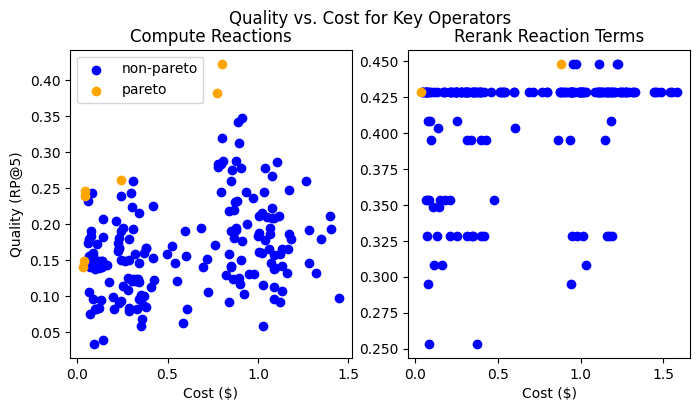

In [67]:
import matplotlib.pyplot as plt

pareto_indices = get_pareto_indices(convert1_costs, convert1_qualities)
non_pareto_convert1_costs = [cost for idx, cost in enumerate(convert1_costs) if not pareto_indices[idx]]
non_pareto_convert1_qualities = [quality for idx, quality in enumerate(convert1_qualities) if not pareto_indices[idx]]
pareto_convert1_costs = [cost for idx, cost in enumerate(convert1_costs) if pareto_indices[idx]]
pareto_convert1_qualities = [quality for idx, quality in enumerate(convert1_qualities) if pareto_indices[idx]]

pareto_indices = get_pareto_indices(convert2_costs, convert2_qualities)
non_pareto_convert2_costs = [cost for idx, cost in enumerate(convert2_costs) if not pareto_indices[idx]]
non_pareto_convert2_qualities = [quality for idx, quality in enumerate(convert2_qualities) if not pareto_indices[idx]]
pareto_convert2_costs = [cost for idx, cost in enumerate(convert2_costs) if pareto_indices[idx]]
pareto_convert2_qualities = [quality for idx, quality in enumerate(convert2_qualities) if pareto_indices[idx]]


fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].scatter(non_pareto_convert1_costs, non_pareto_convert1_qualities, c='blue', label='non-pareto')
axs[0].scatter(pareto_convert1_costs, pareto_convert1_qualities, c='orange', label='pareto')
axs[1].scatter(non_pareto_convert2_costs, non_pareto_convert2_qualities, c='blue', label='non-pareto')
axs[1].scatter(pareto_convert2_costs, pareto_convert2_qualities, c='orange', label='pareto')
axs[0].legend()
axs[0].set_xlabel('Cost ($)')
axs[1].set_xlabel('Cost ($)')
axs[0].set_ylabel('Quality (RP@5)')
axs[0].set_title('Compute Reactions')
axs[1].set_title('Rerank Reaction Terms')
fig.suptitle('Quality vs. Cost for Key Operators')
plt.show()
fig.savefig('quality-vs-cost-key-operators.png', dpi=400)

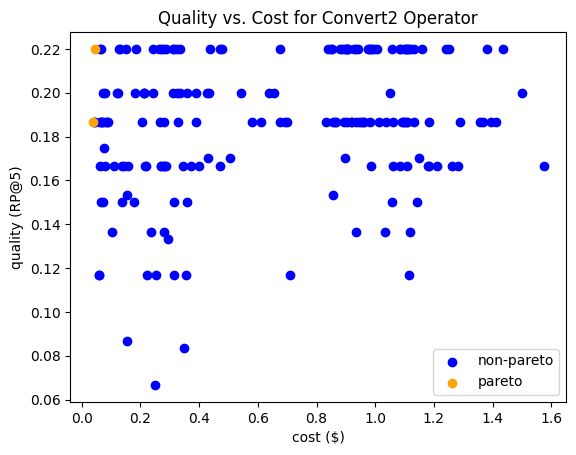

In [45]:
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
ax.scatter(non_pareto_convert2_costs, non_pareto_convert2_qualities, c='blue', label='non-pareto')
ax.scatter(pareto_convert2_costs, pareto_convert2_qualities, c='orange', label='pareto')
ax.legend()
ax.set_xlabel('cost ($)')
ax.set_ylabel('quality (RP@5)')
ax.set_title('Quality vs. Cost for Convert2 Operator')
plt.show()

In [241]:
import pickle
with open("final_results_latest.pkl", "rb") as f:
    results = pickle.load(f)
with open("final_results_003.pkl", "rb") as f:
    second_results = pickle.load(f)

In [308]:
second_results[0]

[200,
 'box',
 ['convert1-op90', 'retrieve1-op0', 'convert2-op5'],
 0.09716853,
 39.93894028663635,
 0.059000000000000004]

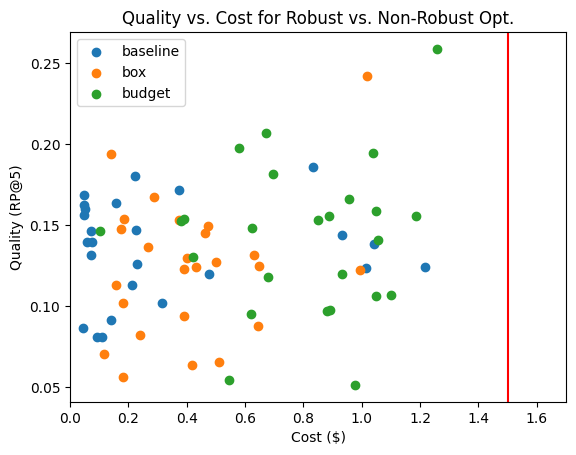

In [242]:
import matplotlib.pyplot as plt

# initial_baseline_data = {
#     # seed_idx: (cost, time, quality)
#     0: (0.04591, 79.30, 0.14633),
#     1: (0.09359, 67.11, 0.17033),
#     2: (0.04714, 83.53, 0.18567),
#     3: (0.04676, 101.93, 0.11367),
#     4: (0.07566, 50.62, 0.18200),
#     5: (0.04564, 79.42, 0.13633),
#     6: (0.07511, 63.40, 0.10700),
#     7: (0.04963, 99.26, 0.11100),
#     8: (0.08186, 43.96, 0.07067),
#     9: (0.05602, 91.95, 0.12300),
#     10: (0.09246, 77.82, 0.15967),
#     11: (0.06993, 98.97, 0.19200),
#     12: (0.04636, 83.45, 0.15233),
#     13: (0.06669, 90.97, 0.20133),
#     14: (0.04503, 84.02, 0.08467),
#     15: (0.07471, 47.74, 0.16100),
#     16: (0.07360, 59.12, 0.17900),
#     17: (0.04805, 86.42, 0.17033),
#     18: (0.10779, 80.49, 0.15167),
#     19: (0.11962, 105.48, 0.14267),
#     20: (0.09210, 71.95, 0.20200),
#     21: (0.08597, 1938.29, 0.09000),
#     22: (0.08911, 67.03, 0.14633),
#     23: (0.08924, 53.71, 0.14733),
#     24: (0.05581, 89.64, 0.18133),
# }
initial_baseline_data = {
    # seed_idx: (cost, time, quality)
    0: (0.04634, 88.17, 0.16233),
    1: (0.07326, 58.53, 0.14633),
    2: (0.11002, 123.33, 0.08067),
    3: (0.83186, 128.19, 0.18567),
    4: (0.93382, 91.22, 0.14367),
    5: (0.04794, 83.58, 0.15633),
    6: (0.22210, 123.43, 0.18033),
    7: (1.01606, 141.12, 0.12367),
    8: (0.09239, 84.88, 0.08067),
    9: (0.37325, 100.99, 0.17167),
    10: (0.04908, 82.25, 0.16833),
    11: (0.21222, 129.58, 0.11300),
    12: (0.31435, 90.82, 0.10167),
    13: (1.04120, 92.06, 0.13833),
    14: (0.04383, 84.93, 0.08667),
    15: (0.22808, 92.25, 0.12567),
    16: (0.07353, 64.16, 0.13133),
    17: (0.15824, 113.58, 0.16367),
    18: (0.13894, 77.83, 0.09167),
    19: (0.07543, 62.34, 0.13967),
    20: (0.22690, 96.79, 0.14667),
    21: (0.05904, 88.68, 0.13967),
    22: (0.05295, 95.56, 0.15967),
    23: (1.21663, 90.18, 0.12400),
    24: (0.47520, 87.95, 0.11967),
}

all_data = []
for result in results:
    uncertainty_set = result[1]
    cost = result[3]
    quality = result[5]
    all_data.append({"label": uncertainty_set, "cost": cost, "quality": quality})

for _, result in initial_baseline_data.items():
    cost, _, quality = result
    all_data.append({"label": "baseline", "cost": cost, "quality": quality})

results_df = pd.DataFrame(all_data)

fig, ax = plt.subplots()
for label, label_df in results_df.groupby('label'):
    xs = label_df.cost.tolist()
    ys = label_df.quality.tolist()
    ax.scatter(xs, ys, label=label)

ax.legend()
ax.axvline(x=1.5, c='r')
ax.set_xlabel('Cost ($)')
ax.set_ylabel('Quality (RP@5)')
ax.set_xlim([0, 1.7])
ax.set_title('Quality vs. Cost for Robust vs. Non-Robust Opt.')
plt.show()
fig.savefig('initial-quality-vs-cost.png', dpi=400)

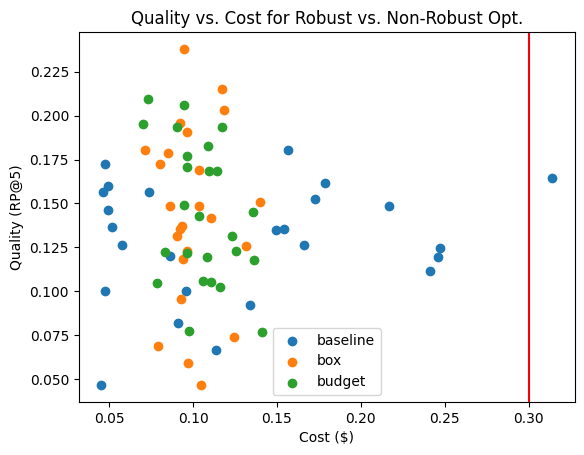

In [325]:
second_baseline_data = {
    # seed_idx: (cost, time, quality)
    0: (0.04936, 152.87, 0.14633),
    1: (0.31413, 106.58, 0.16433),
    2: (0.11375, 126.03, 0.06667),
    3: (0.17852, 127.75, 0.16167),
    4: (0.04638, 86.04, 0.15667),
    5: (0.05741, 101.43, 0.12633),
    6: (0.24120, 133.86, 0.11167),
    7: (0.04755, 100.80, 0.10033),
    8: (0.09121, 79.13, 0.08167),
    9: (0.16626, 115.92, 0.12633),
    10: (0.05196, 85.74, 0.13633),
    11: (0.21689, 90.76, 0.14833),
    12: (0.04921, 81.51, 0.15967),
    13: (0.13384, 84.43, 0.09233),
    14: (0.04532, 77.32, 0.04667),
    15: (0.24614, 115.60, 0.11967),
    16: (0.07370, 57.12, 0.15633),
    17: (0.15431, 87.45, 0.13567),
    18: (0.14972, 95.15, 0.13467),
    19: (0.09561, 88.43, 0.10000),
    20: (0.24695, 161.27, 0.12467),
    21: (0.08623, 2570.13, 0.12033),
    22: (0.04779, 88.33, 0.17233),
    23: (0.15664, 86.00, 0.18033),
    24: (0.17259, 136.69, 0.15233),
}

all_data = []
for result in second_results:
    uncertainty_set = result[1]
    cost = result[3]
    quality = result[5]
    all_data.append({"label": uncertainty_set, "cost": cost, "quality": quality})

for _, result in second_baseline_data.items():
    cost, _, quality = result
    all_data.append({"label": "baseline", "cost": cost, "quality": quality})

results_df = pd.DataFrame(all_data)

fig, ax = plt.subplots()
for label, label_df in results_df.groupby('label'):
    xs = label_df.cost.tolist()
    ys = label_df.quality.tolist()
    ax.scatter(xs, ys, label=label)

ax.legend()
ax.axvline(x=0.3, c='r')
ax.set_xlabel('Cost ($)')
ax.set_ylabel('Quality (RP@5)')
# ax.set_xlim([0, 0.35])
ax.set_title('Quality vs. Cost for Robust vs. Non-Robust Opt.')
plt.show()
fig.savefig('second-quality-vs-cost.png', dpi=400)